In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
print(ls.main_path)

/Users/elenag/Desktop/PlotterLEE/PELEE/


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 08172020


In [5]:
SHRCALIBFACTOR = 1.00

In [6]:
# USING BDT?
USEBDT = True

In [7]:
# Doing Run3?
ISRUN3 = False

In [8]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [9]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [10]:
tree = "NeutrinoSelectionFilter"

BNB = 'neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT = 'neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU  = 'neutrinoselection_filt_run1_overlay'         +ls.APPEND
NUE = 'neutrinoselection_filt_run1_overlay'         +ls.APPEND
DRT = 'neutrinoselection_filt_run1_dirt_overlay'    +ls.APPEND

mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]
#lee = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

#uproot_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]
uproot_v = [mc,nue,ext,data,dirt]
#uproot_v = [ext,data]


variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "shr_pfp_id_v", "category",
    "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
    "shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y",
    "shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y",
    "topological_score",
    #"shr_energy_tot", 
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    "crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy2",
    #"run","sub","evt",
    "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score",
    #"trk_pfp_id",
    "shrmoliereavg","shrmoliererms",
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
    "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
    "trkshrhitdist2", # "trkshrhitdist0","trkshrhitdist1", distance between track and shower in 2D
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trk_llr_pid_score_v", # trk-PID score
    "trk_energy_proton_v", # track energy under proton hyp
    "trk_calo_energy_y_v", # track calo energy
    #"pi0_energy2_Y", # pi0 tagger variables
    "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z","contained_fraction",
    "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","secondshower_Y_dir","shrclusdir2",
    "shr_tkfit_nhits_Y","shr_tkfit_nhits_U","shr_tkfit_nhits_V",
    "shr_tkfit_2cm_nhits_Y","shr_tkfit_2cm_nhits_U","shr_tkfit_2cm_nhits_V",
    "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
    "pfnhits","pfnunhits",
    "trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
    "trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v","shr_id", 
    "pi0_radlen1","pi0_radlen2","pi0_dot1","pi0_dot2","pi0_energy1_Y","pi0_energy2_Y",
    "pi0_dedx1_fit_Y","pi0_dedx2_fit_Y","pi0_shrscore1","pi0_shrscore2","pi0_gammadot",
    "pi0_dedx1_fit_V","pi0_dedx2_fit_V","pi0_dedx1_fit_U","pi0_dedx2_fit_U",
    "pi0_mass_Y","pi0_mass_V","pi0_mass_U",
    "pi0_dir2_x","pi0_dir2_y","pi0_dir2_z","pi0_dir1_x","pi0_dir1_y","pi0_dir1_z",
    "pi0truth_gamma1_etot","pi0truth_gamma2_etot","pi0truth_gammadot","pi0truth_gamma_parent",
    "selected", "topological_score",  "shr_dedx_Y","contained_fraction", "nslice","nu_pdg","category","ccnc","slnunhits","slnhits",
    "backtracked_pdg","shr_bkt_pdg" ,"trk_bkt_pdg","flash_time","flash_pe","reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z","trk_len",
    'trk_len_v','trk_sce_start_x_v','trk_sce_start_y_v','trk_sce_start_z_v',
    'trk_sce_end_x_v','trk_sce_end_y_v','trk_sce_end_z_v',
    'trk_score_v', "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score","CosmicIP","true_e_visible",
    "true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z"
]
#make the list unique
variables = list(set(variables))
print(variables)

#if not ISRUN3:
variables.remove("_closestNuCosmicDist")
variables.remove("crtveto")
variables.remove("crthitpe")
    
WEIGHTS = ["weightSpline","weightTune","weightSplineTimesTune"]#, "weightsGenie", "weightsFlux", "weightsReint"]
WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
           "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
           "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]
SYSTEMATICS = ['weightsFlux','weightsGenie']

nue = nue.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
mc = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)


['shr_dedx_Y', 'shr_theta', 'pfnhits', 'shrsubclusters1', 'shr_dedx_Y_cali', 'interaction', 'pi0_dedx1_fit_V', 'shr_distance', 'pi0_dot2', 'slnhits', 'true_nu_vtx_y', 'trk_len', 'trk_sce_end_x_v', 'trk_bkt_pdg', 'crtveto', 'shr_tkfit_npointsvalid', 'reco_nu_vtx_y', 'reco_nu_vtx_z', 'shrmoliereavg', 'p', 'pt', 'shr_tkfit_nhits_V', 'CosmicDirAll3D', 'pi0_dir2_x', 'reco_nu_vtx_sce_x', 'shr_phi', '_opfilter_pe_veto', 'pi0_dedx1_fit_Y', 'trk_sce_end_y_v', 'shr_dedx_V', 'pi0_shrscore1', 'contained_fraction', 'npion', 'shr_tkfit_nhits_Y', 'pi0_dir1_x', 'shr_energy_tot_cali', 'pi0truth_gamma_parent', 'crthitpe', 'shrclusfrac1', 'shr_energy', 'slclustfrac', 'secondshower_Y_nhit', 'pi0_radlen1', 'shr_tkfit_dedx_V', 'category', 'pi0_mass_Y', 'pi0_dedx1_fit_U', 'secondshower_Y_vtxdist', 'trk_sce_start_y_v', 'shrclusfrac0', 'trk_score_v', 'reco_nu_vtx_x', 'backtracked_pdg', 'trk_energy_proton_v', 'tksh_distance', 'nu_pdg', 'pi0_dir2_y', 'shr_tkfit_gap10_nhits_V', 'pi0_energy1_Y', 'shr_tkfit_2cm_nhi

In [11]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    #if removeGenieTune : 
    #    df[ 'weightTune' ] = 1.
    #    df[ 'weightSplineTimesTune' ] = df['weightSpline']

    #df['weightSpline']  = df['weightSpline']  * df['weightTune']
    #df.loc[ df['npi0'] > 0, 'weightSplineTimesTune' ] = df['weightSpline'] * df['weightTune'] * 0.7 #scale down pi0s

In [34]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!
import time
s = time.time()
df_v = [mc,nue,ext,data,dirt]
#print(f'data shape {data.shape}')
puppa1 = 'trk_score_v'
#print ('trk_llr_pid_score_v' in nue.columns.to_list())
for i,df in enumerate(df_v):
    print(df.shape)
    up = uproot_v[i]
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    
    print(trk_score_v.shape, len(trk_llr_pid_v))
    print(trk_score_v)
#    print(len(c), len(trk_id), len(trk_llr_pid_v))
#    for pidv,puppa,tid,cid in zip(trk_llr_pid_v,trk_score_puppa_v,trk_id,c):
#        if len(pidv) > 0:
#            print(len(pidv),len(puppa), pidv,puppa,tid,cid )
#    nnnnnnnPupppppppaaa = 0
#    print(type(trk_llr_pid_v), trk_llr_pid_v.shape)
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)
    
    #print(df.shape)
    #print(len(puppa_obj))

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])

    #df['n_proton_cand']   = puppa_proton
    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['trkthetacos']     = np.cos(df['trk_theta'])
    #print(  df['N_recoShowers'])
    
s2 = time.time()
print (s-s2)

data shape (263902, 159)
(810812, 193)
(810812,) 810812
[[] [] [] ... [] [] [0.91202915 0.0027221516]]
(810812, 193)
810812
(810812, 176)
(810812,) 810812
[[] [] [] ... [] [] [0.91202915 0.0027221516]]
(810812, 176)
810812
(388803, 171)
(388803,) 388803
[[] [] [] ... [] [0.99298316 0.87471676] []]
(388803, 171)
388803
(263902, 159)
(263902,) 263902
[[] [] [] ... [] [] []]
(263902, 159)
263902
(483722, 164)
(483722,) 483722
[[] [] [] ... [0.8943961] [1.0] []]
(483722, 164)
483722
-73.52488088607788


In [35]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

df_v = [mc,nue,ext,data,dirt]
#df_v = [lee,mc,nue,ext,data,dirt]

for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['protonenergy'] = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y'] = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['trkthetacos'] = np.cos(df['trk_theta'])
    #df['FMdiffOBV'] = df['nu_flashmatch_score']-df['best_obviouscosmic_flashmatch_score']
    #df['FMdiff'] = df['nu_flashmatch_score']-df['best_cosmic_flashmatch_score']

In [36]:
for i,df in enumerate(df_v):
    up = uproot_v[i]
    #trk_score_v = up.array('trk_score_v')
    trk_sce_start_x_v = up.array('trk_sce_start_x_v')
    trk_sce_start_y_v = up.array('trk_sce_start_y_v')
    trk_sce_start_z_v = up.array('trk_sce_start_z_v')
    trk_sce_end_x_v = up.array('trk_sce_end_x_v')
    trk_sce_end_y_v = up.array('trk_sce_end_y_v')
    trk_sce_end_z_v = up.array('trk_sce_end_z_v')
    shr_id = up.array('shr_id')-1 # I think we need this -1 to get the right result
    #trk_score_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_score_v,shr_id)])
    trk_sce_start_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_x_v,shr_id)])
    trk_sce_start_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_y_v,shr_id)])
    trk_sce_start_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_z_v,shr_id)])
    trk_sce_end_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_x_v,shr_id)])
    trk_sce_end_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_y_v,shr_id)])
    trk_sce_end_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_z_v,shr_id)])
    #df['shr_score_check'] = trk_score_v_sel
    df['shr_trk_sce_start_x'] = trk_sce_start_x_v_sel
    df['shr_trk_sce_start_y'] = trk_sce_start_y_v_sel
    df['shr_trk_sce_start_z'] = trk_sce_start_z_v_sel
    df['shr_trk_sce_end_x'] = trk_sce_end_x_v_sel
    df['shr_trk_sce_end_y'] = trk_sce_end_y_v_sel
    df['shr_trk_sce_end_z'] = trk_sce_end_z_v_sel   

In [37]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    #
    # secondshower_U/V/Y_dot need to be set to 9999. to match data ntuples produced with v08_00_00_43 or later;
    # the patch below is valid only to match data ntuples produced with v08_00_00_42.
    #
    #df.loc[df['secondshower_U_dot'].isna(),'secondshower_U_dot'] = 0.0 #for 0p please uncomment
    #df.loc[df['secondshower_V_dot'].isna(),'secondshower_V_dot'] = 0.0 #for 0p please uncomment
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [38]:
#
for i,df in enumerate(df_v):
    up = uproot_v[i]
    df["slclnhits"] = up.array("pfnhits").sum()
    df["slclnunhits"] = up.array("pfnunhits").sum()
#

In [39]:
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
    df['shr_tkfit_dedx_avg'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [40]:
#reset timing
df_v = [mc,nue,dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

df_v = [ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359

In [106]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])

# test calibrating dedx on Y plane
#data["shr_tkfit_gap10_dedx_Y"] = data["shr_tkfit_gap10_dedx_Y"]*1.03
#ext["shr_tkfit_gap10_dedx_Y"] = ext["shr_tkfit_gap10_dedx_Y"]*1.03
#data["shr_tkfit_2cm_dedx_Y"] = data["shr_tkfit_2cm_dedx_Y"]*1.03
#ext["shr_tkfit_2cm_dedx_Y"] = ext["shr_tkfit_2cm_dedx_Y"]*1.03
#data["shr_tkfit_dedx_Y"] = data["shr_tkfit_dedx_Y"]*1.03
#ext["shr_tkfit_dedx_Y"] = ext["shr_tkfit_dedx_Y"]*1.03

In [107]:
# add back the cosmic category, for background only
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [108]:
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [109]:
# variables to be trained on
TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_dedx_max","trkfit","trkpid",
            "subcluster","shrmoliereavg",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            "CosmicIPAll3D","CosmicDirAll3D"]

In [110]:
LABELS = ['pi0','nonpi0']

if (USEBDT == True):
    for label, bkg_query in zip(LABELS, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_0304_extnumi.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            #print((ls.pickle_path+'booster_%s_0304_extnumi.model' % label), booster.best_iteration)
            #booster.save_model( (ls.pickle_path+'booster_%s_0304_extnumi.model' % label) )
            mc[label+"_score"] = booster.predict(
                xgb.DMatrix(mc[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nue[label+"_score"] = booster.predict(
                xgb.DMatrix(nue[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ext[label+"_score"] = booster.predict(
                xgb.DMatrix(ext[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            data[label+"_score"] = booster.predict(
                xgb.DMatrix(data[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            dirt[label+"_score"] = booster.predict(
                xgb.DMatrix(dirt[TRAINVAR]),
                ntree_limit=booster.best_iteration)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [111]:
dfbdt_v = [mc,nue,ext,data,dirt]

# Plotting part

In [112]:
import plotterPOT
import importlib
importlib.reload(plotterPOT)

<module 'plotterPOT' from '/Users/elenag/Desktop/PlotterLEE/PELEE2/plotterPOT.py'>

In [113]:
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.


nue = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
samples = {
    "mc": mc,
    "nue": nue,
    "dirt": dirt,
    "data": data,
    "ext": ext
}

scaling = 1
#scaling = 0.789
pot = 8.885e+19 #9.789e+19 
mcratio   = pot/2.07136e+21
dirtratio = pot/1.42143e+21
extratio  = 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.45

weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : mcratio  * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}

my_plotter = plotterPOT.plotterPOT(samples, weights, pot=pot)
print(weights)

{'mc': 0.04289452340491271, 'nue': 0.04289452340491271, 'ext': 0.5729113237946756, 'dirt': 0.02812836369008674}


In [114]:
# muon selection
QUERY = 'nslice == 1'
#QUERY += ' and trk_sce_end_y_v < 110'
#if ISRUN3: QUERY += ' and ((crtveto!=1) or (crthitpe < 100)) and (_closestNuCosmicDist > 20.)'
#QUERY += ' and n_tracks_contained >= 1'
#QUERY += ' and topological_score > 0.06'
#QUERY += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251'
#QUERY += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110'
#QUERY += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986'
#QUERY += ' and trkpid > 0.5'
#QUERY += ' and (trkthetacos < 0.853 or trkthetacos > 0.8531)'
#QUERY += ' and bkpdg == 2212 and (trkcompl < 0.5 or trkpur < 0.5)'

print (QUERY)

nslice == 1


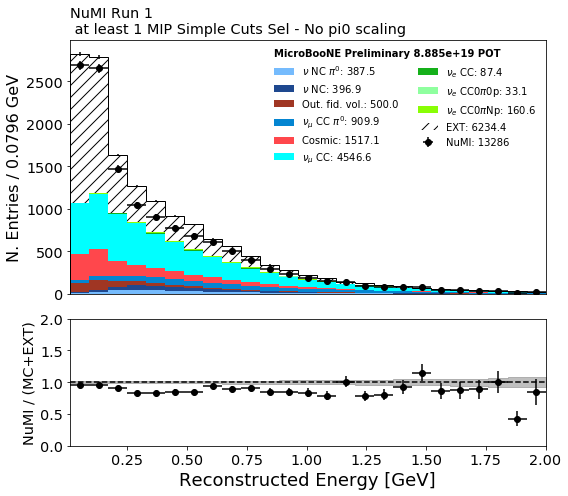

In [133]:
import matplotlib.pyplot as plt
import matplotlib

QUERY = 'nslice == 1 and N_recoTrks > 1 and N_recoProtons >= 0 and N_recoShowers >= 0 and N_recoMuons >= 1 '# and reco_nu_vtx_sce_x < 10 and reco_nu_vtx_sce_y < 0 '# and trackcaloenergy < 0.1'# and (trkthetacos > 0.86 or trkthetacos < 0.85)'

VARIABLE, BINS, RANGE, XTIT = 'reco_e',25,(0.01,2.0),"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'flash_time',1,(0,25.),"flash time"
#VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',27,(-200,1260.0),"flash time"
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,#BDTCQ,#NPLCUTQ, #QUERY, #'nslice == 1', #QUERY, #+" and category != 111",
    kind="event_category",
    #kind="sample",
    #kind="interaction",
    #kind='particle_pdg',
    draw_sys=False,
    stacksort=3,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)[0:3]

#print("Profile likelihood: %.2f sigma @ 1.01e21 POT" % my_plotter.significance_likelihood)
#print("s/sqrt(b): %.2f sigma @ 1.01e21 POT" % my_plotter.significance)

#ax1.set_ylim(0,40)
#ax1.set_yscale("log")
#ax1.set_ylim(0,240)
#ax1.set_yscale('log')
#ax1.set_ylim(0,ax1.get_ylim()[1]*1.25)
#ax2.set_ylim(0.,2.)

ax1.set_title('NuMI Run 1 \n at least 1 MIP Simple Cuts Sel - No pi0 scaling',loc='left')
fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/NuMI/Dirt/"+VARIABLE+"_Slice1.pdf")

In [ ]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

In [ ]:
TWOSHWRS = PRESQ
TWOSHWRS += ' and n_showers_contained >= 2'


In [ ]:
# 1eNp preselection
NPPRESQ = PRESQ
NPPRESQ += ' and n_tracks_contained > 0'

In [ ]:
# very loose box cuts
NPVLCUTQ = NPPRESQ
NPVLCUTQ += ' and CosmicIPAll3D > 10.'
NPVLCUTQ += ' and trkpid < 0.25'
NPVLCUTQ += ' and hits_ratio > 0.5'
NPVLCUTQ += ' and trkfit < 0.90'
NPVLCUTQ += ' and n_showers_contained == 1'
NPVLCUTQ += ' and tksh_distance < 10.0'
NPVLCUTQ += ' and tksh_angle > -0.9'

In [ ]:
# loose box cuts
NPLCUTQ = NPVLCUTQ
NPLCUTQ += ' and CosmicIPAll3D > 10.'
NPLCUTQ += ' and trkpid < 0.02'
NPLCUTQ += ' and hits_ratio > 0.50'
NPLCUTQ += ' and shrmoliereavg < 9'
NPLCUTQ += ' and subcluster > 4'
NPLCUTQ += ' and trkfit < 0.65'
NPLCUTQ += ' and n_showers_contained == 1'
NPLCUTQ += ' and tksh_distance < 6.0'
NPLCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQ += ' and secondshower_Y_nhit < 50'
NPLCUTQ += ' and tksh_angle > -0.9'

In [ ]:
NPLCUTQPlus = NPPRESQ
NPLCUTQPlus += ' and CosmicIPAll3D > 10.'
NPLCUTQPlus += ' and trkpid < 0.25'
NPLCUTQPlus += ' and hits_ratio > 0.5'
NPLCUTQPlus += ' and trkfit < 0.90'
NPLCUTQPlus += ' and tksh_distance < 10.0'
NPLCUTQPlus += ' and tksh_angle > -0.9'
NPLCUTQPlus += ' and CosmicIPAll3D > 10.'
NPLCUTQPlus += ' and trkpid < 0.02'
NPLCUTQPlus += ' and hits_ratio > 0.50'
NPLCUTQPlus += ' and shrmoliereavg < 9'
NPLCUTQPlus += ' and subcluster > 4'
NPLCUTQPlus += ' and trkfit < 0.65'
#NPLCUTQPlus += ' and n_showers_contained > 1'
NPLCUTQPlus += ' and tksh_distance < 6.0'
NPLCUTQPlus += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQPlus += ' and secondshower_Y_nhit < 50'
NPLCUTQPlus += ' and tksh_angle > -0.9'

In [ ]:
# tight box cuts
NPTCUTQ = NPLCUTQ
NPTCUTQ += ' and CosmicIPAll3D > 30.'
NPTCUTQ += ' and CosmicDirAll3D > -0.98 and CosmicDirAll3D < 0.98'
NPTCUTQ += ' and trkpid < 0.02'
NPTCUTQ += ' and hits_ratio > 0.65'
NPTCUTQ += ' and shr_score < 0.25'
NPTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 10'
NPTCUTQ += ' and subcluster > 7'
NPTCUTQ += ' and trkfit < 0.70'
NPTCUTQ += ' and n_showers_contained == 1'
NPTCUTQ += ' and tksh_distance < 4.0'
NPTCUTQ += ' and trkshrhitdist2 < 1.5'
NPTCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 1.0 and shr_tkfit_dedx_max < 3.8)'
NPTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
NPTCUTQ += ' and secondshower_Y_nhit < 30'
NPTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.70'

In [ ]:
# OLD loose box cuts
OLCUTQ = PRESQ
OLCUTQ += ' and CosmicIP > 20.'
OLCUTQ += ' and trkpid < 0.1'
OLCUTQ += ' and hits_ratio > 0.5'
OLCUTQ += ' and shr_score < 0.30'
OLCUTQ += ' and n_showers_contained == 1'
OLCUTQ += ' and tksh_distance < 6.0'
OLCUTQ += ' and shr_tkfit_2cm_dedx_avg < 4.0'
OLCUTQ += ' and tksh_angle > -0.9'
# OLD tight box cuts
OTCUTQ = OLCUTQ
OTCUTQ += ' and tksh_distance < 3.5'
OTCUTQ += ' and (shr_tkfit_2cm_dedx_Y > 0 and shr_tkfit_2cm_dedx_Y < 4.0 and shr_tkfit_2cm_dedx_U < 4.0 and shr_tkfit_2cm_dedx_V < 4.0)'
OTCUTQ += ' and (shr_tkfit_gap10_dedx_Y > 0 and shr_tkfit_gap10_dedx_Y < 4.5 and shr_tkfit_gap10_dedx_U < 4.5 and shr_tkfit_gap10_dedx_V < 4.5)'
OTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.75'
OTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 9'
OTCUTQ += ' and trkpid < -0.02'
OTCUTQ += ' and n_showers_contained == 1'
OTCUTQ += ' and shr_score < 0.275'
OTCUTQ += ' and hits_ratio > 0.60'
OTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
OTCUTQ += ' and (trkfit < 0.45 or subcluster > 6)'

In [ ]:
# BDT cuts
# 0304 extnumi, pi0 and nonpi0
BDTCQ = NPPRESQ
BDTCQ += ' and pi0_score > 0.67 and nonpi0_score > 0.70'

In [ ]:
myPre = "nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0"

In [ ]:
# loose box cuts
NPLCUTQ2 = NPPRESQ
NPLCUTQ2 += ' and CosmicIPAll3D > 10.'
NPLCUTQ2 += ' and hits_ratio > 0.5'
NPLCUTQ2 += ' and trkfit < 0.90'
NPLCUTQ2 += ' and n_showers_contained == 1'
NPLCUTQ2 += ' and tksh_distance < 10.0'
NPLCUTQ2 += ' and tksh_angle > -0.9'
NPLCUTQ2 += ' and CosmicIPAll3D > 10.'
#NPLCUTQ2 += ' and trkpid < 0.02'
NPLCUTQ2 += ' and hits_ratio > 0.50'
NPLCUTQ2 += ' and shrmoliereavg < 9'
NPLCUTQ2 += ' and subcluster > 4'
NPLCUTQ2 += ' and trkfit < 0.65'
NPLCUTQ2 += ' and n_showers_contained == 1'
NPLCUTQ2 += ' and tksh_distance < 6.0'
NPLCUTQ2 += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQ2 += ' and secondshower_Y_nhit < 50'
NPLCUTQ2 += ' and tksh_angle > -0.9'

In [ ]:
SCORECUT = 0.5 # 0.75 #75 # max track score                                                                                                                                                                        
DVTX = 3.0 # 3. # distance from vertex of each shower                                                                                                                                                              
VTXDOT = 0.8 # dot product between each shower's direction and the vtx -> shr start vector                                                                                                                         
EMIN1 =  60 #150 #60   # leading photon min energy                                                                                                                                                                        
EMIN2 =  40 #100 #40   # subleading photon min energy                                                                                                                                                          
GAMMADOT = 0.94 #0 #0.94 # max dot product between showres                                                                                                                                                                  
DEDXCUT = 1.0 # MeV/cm cut on leading shower only                                                                                                                                                                  
PI0SEL = 'nslice == 1'
PI0SEL += ' & pi0_shrscore1 < %f & pi0_shrscore2 < %f'%(SCORECUT,SCORECUT)
PI0SEL += '& pi0_dot1  > %f & pi0_dot2 > %f '%(VTXDOT,VTXDOT)
PI0SEL += ' & pi0_radlen1 > %f & pi0_radlen2 > %f & pi0_gammadot < %f '%(DVTX,DVTX,GAMMADOT)
PI0SEL += ' & pi0_energy1_Y > %f & pi0_energy2_Y > %f'%(EMIN1,EMIN2)
#PI0SEL += ' and (filter_pi0 == 1 or bnbdata==1 or extdata==1)'                                                                                                                                                    
#PI0SEL += ' and (filter_pi0 == 1)'                                                                                                                                                                                
PI0SEL += ' and pi0_dedx1_fit_Y >= %f'%DEDXCUT

In [ ]:
NUMUOnTheFly = 'nslice == 1 and topological_score > 0.06 '
NUMUOnTheFly += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251'
NUMUOnTheFly += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110'
NUMUOnTheFly += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986'
NUMUOnTheFly += ' and trk_score > 0.8 and trk_len > 10 and trk_distance < 4'

In [ ]:
# Define actual selection
# QUERY = NPTCUTQ #NPTCUTQ
#QUERY = NPPRESQ
#QUERY = NPLCUTQ #NPTCUTQ NPLCUTQ
#QUERY = NPPRESQ 
QUERY = NPLCUTQ +" and "+ BDTCQ #PI0SEL#NUMUOnTheFly + ' and n_showers_contained == 1'  #PI0SEL#NPLCUTQ2 #NPLCUTQ #NPPRESQ#'nslice ==1 ' #NPPRESQ #PRESQ
# in case you do not want to look at the data
#QUERY += ' and bnbdata==0'
# in case you want to apply the CRT veto
#if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'

In [ ]:
print(NPLCUTQPlus)

In [ ]:
KSEL = 'nslice == 1'
KSEL += ' and selected == 1'
KSEL += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251'
KSEL += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110'
KSEL += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986'
KSEL += ' and contained_fraction > 0.9'
KSEL += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
KSEL += ' and shr_energy_tot_cali > 0.07'
KSEL += ' and n_tracks_contained > 0'
KSEL += ' and n_showers_contained == 1'
KSEL += ' and subcluster > 6'
KSEL += ' and shrmoliereavg < 10'
KSEL += ' and tksh_distance < 6.0'
KSEL += ' and shr_tkfit_dedx_max < 0.0'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
# v = "$\cos\left(\theta_{\mu}\right)$"

#QUERY += " & pi0truth_elec_etot<15 & npi0 == 0 & ccnc == 0"
#QUERY += " & muon_e>0.3 & npi0 == 0 & ccnc == 0"
#QUERY = "(muon_e<0.3 | pi0truth_elec_etot>=15) & npi0 == 0 & npion == 0 & ccnc == 0 & nu_pdg == 14 & category == 2"
#QUERY += " & ~((muon_e<0.3 | pi0truth_elec_etot>=15) & npi0 == 0 & npion == 0 & ccnc == 0 & nu_pdg == 14 & category != 5)"

QUERY = KSEL
#VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.15,2.15), r"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'pi0_mass_Y',100,(0,1000.),"pi0 mass Y"
VARIABLE, BINS, RANGE, XTIT = 'shr_tkfit_dedx_max',25,(-1000000,0.),"dedx fit max"
#VARIABLE, BINS, RANGE, XTIT = 'trk_len',50,(0,400.),"track length"

#VARIABLE, BINS, RANGE, XTIT = 'pi0_gammadot',10,(-1.,1.0),r" pi0 gammadot "
#VARIABLE, BINS, RANGE, XTIT = 'topological_score',25,(0,1),r"topological score"
#VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',20,(-10,260),"x"
#VARIABLE, BINS, RANGE, XTIT = 'nonpi0_score',10,(0.5,1.5),"non pi0 score"

#VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',10,(0.,10.),r"n showers contained"
#VARIABLE, BINS, RANGE, XTIT = 'pi0truth_elec_etot',20,(0.,60),r"Michel Energy [GeV]"
#QUERY = PI0SEL #NPLCUTQ2#BDTCQ+" and "+NPLCUTQ
#fig, ax1, ax2 = my_plotter.plot_variable(
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,#BDTCQ,#NPLCUTQ, #QUERY, #'nslice == 1', #QUERY, #+" and category != 111",
    kind="event_category",
    #kind="sample",
    #kind="interaction",
    #kind='particle_pdg',
    draw_sys=False,
    stacksort=3,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)[0:3]

#print("Profile likelihood: %.2f sigma @ 1.01e21 POT" % my_plotter.significance_likelihood)
#print("s/sqrt(b): %.2f sigma @ 1.01e21 POT" % my_plotter.significance)

#ax1.set_ylim(0,40)
#ax1.set_yscale("log")
#ax1.set_ylim(0,240)
#ax1.set_yscale('log')
#ax1.set_ylim(0,ax1.get_ylim()[1]*1.25)
#ax2.set_ylim(0.,2.)

ax1.set_title('NuMI Run 1 \n1eNp BDT Sel - No pi0 scaling',loc='left')
fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/"+VARIABLE+".pdf")
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/Pi0/"+VARIABLE+"_noScale.pdf")

In [ ]:
VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.15,2.15), r"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,
    kind="event_category",
    draw_sys=False,
    stacksort=3,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)[0:3]

ax1.set_title('NuMI Run 1 \n1eNp BDT Sel - No pi0 scaling',loc='left')
fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTSel/"+VARIABLE+".pdf")

In [ ]:
print(NPLCUTQ)
print()
print(BDTCQ)
print()
print(myPre)

In [ ]:
print(data.query(QUERY)[["run","sub","evt","reco_e"]])
#tablevars = ["run","sub","evt","reco_e","pi0_score","nonpi0_score"]
tablevars = ["run","sub","evt"]
tablevars+=TRAINVAR
print(tablevars)
#data.query(PRESQ+" & run==14822")[tablevars]
#data.query("run==5151")[tablevars]


In [ ]:
mc.query(QUERY+"& ccnc==0 & nu_pdg==14 & mcf_np0==0")[["run","sub","evt","reco_e","mcf_lep_e","mcf_mcshr_elec_etot"]]

In [ ]:
QUERY = BDTCQ+" and "+NPLCUTQ#+" and reco_e < 0.5" #NPLCUTQ2# BDTCQ #BDTCQ+" and "+NPLCUTQ
print(QUERY)

scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.


nue = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
samples = {
    "mc": mc,
    "nue": nue,
    "dirt": dirt,
    "data": data,
    "ext": ext
}

scaling = 1
pot = 8.885e+19 #9.789e+19 
mcratio   = pot/2.07136e+21
dirtratio = pot/1.42143e+21
extratio  = 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.45

weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : mcratio  * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT,
            "dirt": dirtratio* SPLIT * scalingDRT   
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

plots = []
'''
plots.append(['shr_score',20,(0,0.5),"shr score"])
plots.append(['tksh_distance',5,(0,5),"tksh distance [cm]"])
plots.append(['tksh_angle',10,(-1,1),"cos(tksh angle)"])
plots.append(['shr_tkfit_dedx_max',15,(0,10),"shr tkfit dE/dx (best-plane, 0-4 cm) [MeV/cm]"])
plots.append(['trkfit',10,(0,1),"Fraction of Track-fitted points"])
plots.append(['trkpid',10,(-1,1),"track LLR PID"])
plots.append(['shrmoliereavg',10,(0,25),"average Moliere angle [degrees]"])
plots.append(['subcluster',15,(0,60),"N sub-clusters in shower"])
plots.append(['hits_ratio',20,(0,1),"shower hits/all hits"])
plots.append(['trkshrhitdist2',16,(-1,15),"2D trk-shr distance (Y)"])
plots.append(['secondshower_Y_nhit',20,(0,200),"Nhit 2nd shower (Y)"])
plots.append(['secondshower_Y_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (Y)"])
plots.append(['secondshower_Y_vtxdist',20,(0.,400),"vtx dist 2nd shower (Y)"])
plots.append(['anglediff_Y',10,(0,360),"angle diff 1st-2nd shower (Y) [degrees]"])
plots.append(['CosmicIPAll3D',10,(0,200),"CosmicIPAll3D [cm]"])
plots.append(['CosmicDirAll3D',10,(-1,1),"cos(CosmicDirAll3D)"])
plots.append(['reco_nu_vtx_sce_y',15,(-150,150),"reco nu vtx y [cm]"])
'''        
#plots.append(['shr_tkfit_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_max',20,(0,10),"shr tkfit dE/dx (best-plane, 0-4 cm) [MeV/cm]"])
#plots.append(['n_showers_contained',10,(0,10),"n showers contained"])
plots.append(['n_tracks_contained',5,(0,5),"n tracks contained"])
plots.append(['protonenergy',10,(0.,0.5),"Proton Kinetic Energy [GeV]"])
plots.append(['trk_theta',10,(0,3.0),"Track theta"])
plots.append(['shr_theta',10,(0,3.0),"Shower theta"])
plots.append(['pt',10,(0,2.),"Pt [GeV]"])
plots.append(['shr_phi',10,(-3,3),"Shower phi"])
plots.append(['shr_energy_tot_cali',20,(0,2),"shr energy (calibrated) [GeV]"])
#plots.append(['reco_nu_vtx_sce_z',20,(0,1100),"z"])
#plots.append(['reco_e_rqe',20,(0,2),"rqe"])
#plots.append(['shrmoliererms',20,(0,5000),"RMS Moliere angle [degrees]"])

#plots.append(['contained_fraction',20,(0.,1),"contained fraction"])
#plots.append(['hits_y',20,(0.,1000),"N hits Y plane"])
#plots.append(['pi0_mass_Y',25,(-50.,200),"pi0 mass [Mev]"])
#plots.append(['pi0_gammadot',20,(-1,1),"2-shower angle"])
if USEBDT:
    #plots = []
    #plots.append(['pi0_score',20,(0.9,1),"$\pi^0$ BDT response"])
    #plots.append(['nonpi0_score',20,(0.9,1),"non-$\pi^0$ BDT response"])
    #plots.append(['pi0_score',10,(0.,0.5),"$\pi^0$ BDT response"])
    #plots.append(['nonpi0_score',10,(0.,0.5),"non-$\pi^0$ BDT response"])
    plots.append(['pi0_score',10,(0,1.0),"$\pi^0$ BDT response"])
    plots.append(['nonpi0_score',10,(0,1.0),"non-$\pi^0$ BDT response"])
#plots = []
#plots.append(['tksh_distance',20,(0,10),"tksh distance [cm]"])

#plots.append(['secondshower_Y_nhit',20,(0,200),"Nhit 2nd shower (Y)"])
#plots.append(['secondshower_Y_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (Y)"])
#plots.append(['anglediff_Y',20,(0,350),"angle diff 1st-2nd shower (Y) [degrees]"])
#plots.append(['secondshower_Y_vtxdist',20,(0.,200),"vtx dist 2nd shower (Y)"])
for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    #ax1.set_ylim(0,ax1.get_ylim()[1]*1.4)
    #ax1.set_yscale("log")
    #fig.show()
    #ax1.set_title('NuMI Run 1 \n1eNp Loose Box Cuts - No pi0 scaling',loc='left')
    ax1.set_title('NuMI Run 1 \n1eNp BDT Sel. - No pi0 scaling',loc='left')
    fig.tight_layout()
    #fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/"+VARIABLE+".pdf")
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTSel/"+VARIABLE+".pdf")
    #fig.savefig(ls.plots_path+""+VARIABLE+"_highscore.pdf")
    #break

In [ ]:
QUERY == BDTCQ+" and "+NPLCUTQ+" and reco_e < 0.5"
print(QUERY)
f = data.query(QUERY)[["run","sub"]]#.to_string(index=False)
query4SamWeb = f.apply(lambda x: str(x['run'])+'.'+str(x['sub'])+',', axis=1).sum()
print("defname: numi_uboone_run1_beamon_offset1_mcc9_reco2_v08_00_00_28_v0 and run_number "+query4SamWeb)

f = data.query(QUERY)[["run","sub","evt","reco_e"]]
print (f)

In [ ]:


QUERY = PI0SEL
plots = []

plots.append(['pi0_dedx1_fit_Y',20,(0,10),"pi0 dedx1 fit Y [MeV/cm]"])
plots.append(['pi0_dedx2_fit_Y',20,(0,10),"pi0 dedx2 fit Y [MeV/cm]"])
plots.append(['tksh_distance',20,(0,60),"tksh distance [cm]"])
plots.append(['pi0_energy1_Y',26,(0.,650),"pi0 energy1 [Mev]"])    
plots.append(['pi0_energy2_Y',26,(0.,650),"pi0 energy2 [Mev]"])    
plots.append(['pi0_mass_Y',25,(0.,500),"pi0 mass [Mev]"])
plots.append(['pi0_gammadot',20,(-1,1),"2-shower angle"])

for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    ax1.set_title('NuMI Run 1 \nPi0 Sel - No pi0 scaling',loc='left')
    fig.tight_layout()
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/Pi0/"+VARIABLE+"_noScale.pdf")


In [ ]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTune']


In [ ]:
scaleFlat = 2
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTune' ] =  (df['weightSplineTimesTune'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTune'] = df['weightSplineTimesTune']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTune'] = df['weightSplineTimesTune']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 


In [ ]:
import plotter
import importlib
importlib.reload(plotter)

In [ ]:
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.


nue = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
samples = {
    "mc": mc,
    "nue": nue,
    "dirt": dirt,
    "data": data,
    "ext": ext
}

scaling = 1
#scaling = 0.759
pot = 8.885e+19 #9.789e+19 
mcratio   = pot/2.07136e+21
dirtratio = pot/1.42143e+21
extratio  = 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.45

weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "ncpi0"  : 10.,
            "nue" : mcratio  * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT,
            "dirt": dirtratio* SPLIT * scalingDRT   
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)
QUERY = PI0SEL
plots = []

plots.append(['pi0_dedx1_fit_Y',20,(0,10),"pi0 dedx1 fit Y [MeV/cm]"])
plots.append(['pi0_dedx2_fit_Y',20,(0,10),"pi0 dedx2 fit Y [MeV/cm]"])
plots.append(['tksh_distance',20,(0,60),"tksh distance [cm]"])
plots.append(['pi0_energy1_Y',26,(0.,650),"pi0 energy1 [Mev]"])    
plots.append(['pi0_energy2_Y',26,(0.,650),"pi0 energy2 [Mev]"])    
plots.append(['pi0_mass_Y',25,(0.,500),"pi0 mass [Mev]"])
plots.append(['pi0_gammadot',20,(-1,1),"2-shower angle"])

for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",#"event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]

    
    if scaleFlat == 1:
        ax1.set_title('NuMI Run 1 \nPi0 Sel - Pi0 Scaling: flat 0.759',loc='left')
        fig.tight_layout()
        fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/Pi0/"+VARIABLE+"_FlatScale.pdf")
    elif scaleFlat == 2:
        ax1.set_title('NuMI Run 1 \nPi0 Sel - Pi0 Scaling: [1-0.4 E_pi0]',loc='left')
        fig.tight_layout()
        fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/Pi0/"+VARIABLE+"_ScaleE.pdf")
    elif scaleFlat == 0:
        ax1.set_title('NuMI Run 1 \nPi0 Sel - Pi0 Scaling: none',loc='left')
        fig.tight_layout()
        fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/Pi0/"+VARIABLE+"_NoScale.pdf")



In [ ]:
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

ZPPRESEL = PRESQ
ZPPRESEL += ' and n_tracks_contained == 0'
ZPPRESEL_one_shower = ZPPRESEL + 'and n_showers_contained == 1'

ZPLOOSESEL = ZPPRESEL
ZPLOOSESEL += ' and n_showers_contained == 1'
ZPLOOSESEL += ' and CosmicIPAll3D > 10.'
ZPLOOSESEL += ' and CosmicDirAll3D > -0.9 and CosmicDirAll3D < 0.9'
ZPLOOSESEL += ' and shrmoliereavg < 15'
ZPLOOSESEL += ' and subcluster > 4'
ZPLOOSESEL += ' and trkfit < 0.65'
ZPLOOSESEL += ' and secondshower_Y_nhit < 50'
ZPLOOSESEL += ' and shr_trk_sce_start_y > -100 and shr_trk_sce_start_y < 80'
ZPLOOSESEL += ' and shr_trk_sce_end_y > -100 and shr_trk_sce_end_y < 100 '
ZPLOOSESEL += ' and shr_trk_len < 300.'
ZPLOOSESEL += ' and (n_tracks_tot == 0 or (n_tracks_tot>0 and tk1sh1_angle_alltk>-0.9))'
ZPLOOSESEL += ' and n_tracks_contained == 0'

ZPBDT = ZPLOOSESEL
ZPBDT += ' and bkg_score >0.85'

QUERY = ZPBDT

In [ ]:
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.


nue = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
samples = {
    "mc": mc,
    "nue": nue,
    "dirt": dirt,
    "data": data,
    "ext": ext
}

scaling = 1
#scaling = 0.759
pot = 8.885e+19 #9.789e+19 
mcratio   = pot/2.07136e+21
dirtratio = pot/1.42143e+21
extratio  = 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.45

weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : mcratio  * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)
plots = []

plots.append(['reco_e',20,(0,10),"reco E [MeV]"])

for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    ax1.set_title('NuMI Run 1',loc='left')
    fig.tight_layout()